# Unsupervised Language Learning, Lab1

## Adriaan de Vries (10795227), Verna Dankers (10761225)

Hier komt een verhaaltje over de eerste opdracht.

Before being able to run this code, please import the following libraries and set the following paths to the datasets. Afterwards, the code should run without issues.

In [25]:
# Requirements
from tqdm import tqdm
from pprint import pprint
from collections import defaultdict, Counter
from scipy.stats import spearmanr, pearsonr
from tabulate import tabulate
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.vq import whiten, kmeans

# Paths to datasets
bow2_filename = "data/bow2.words"
bow5_filename = "data/bow5.words"
deps_filename = "data/deps.words"
simlex_filename = "data/SimLex-999.txt"
men_filename = "data/men/MEN_dataset_natural_form_full"
analogy_filename = "data/questions-words.txt"
common_words_filename = "data/common_words.words"

### 1. Collect and examine the word embeddings

In [2]:
def read_data(filename):
    """Create a dictionary that maps vocabulary terms to their word embedding.

    Args:
        filename: string referring to the file we are reading embeddings from
    
    Returns:
        dict: dictionary mapping words to embeddings
    """
    # Initialize dictionary and open the file
    data = {}
    f = open(filename, 'r')
    i = 0

    # Continue until end of file
    while True:
        i += 1
        if i % 50000 == 0:
            print("Processed {} lines for file {}.".format(i, filename))
        try:
            line = f.readline()

        # We'll ignore the one line in deps that has a non-unicode character (possibly ü)
        except UnicodeDecodeError:
            continue
        if not line:
            f.close()
            return data
        line = line.split()

        # Ignore vectors that have more than 300 elements
        if len(line) != 301:
            continue

        # Ensure that the vectors are normalized, this is useful later on
        vector = np.array([float(x) for x in line[1:]])
        data[line[0]] = vector
        # there's also a misplaced character in deps, possibly because split splits a strange word into two words

In [3]:
bow5 = read_data(bow5_filename)
bow2 = read_data(bow2_filename)
deps = read_data(deps_filename)

Processed 50000 lines for file data/bow5.words.
Processed 100000 lines for file data/bow5.words.
Processed 150000 lines for file data/bow5.words.
Processed 50000 lines for file data/bow2.words.
Processed 100000 lines for file data/bow2.words.
Processed 150000 lines for file data/bow2.words.
Processed 50000 lines for file data/deps.words.
Processed 100000 lines for file data/deps.words.
Processed 150000 lines for file data/deps.words.


In [4]:
def get_closest_word_to_vec(vec, data):
    best = 0
    vec = vec / np.linalg.norm(vec)
    for key in data:
        comp = data[key] / np.linalg.norm(data[key])
        val = np.dot(vec, comp)
        if val > best:
            best = val
            best_word = key
    return best_word
            
def get_closest_word_to_word(word, data):
    vec = data[word] / np.linalg.norm(data[word])
    best = 0
    for key in data:
        if key == word:
            continue
        comp = data[key] / np.linalg.norm(data[key])
        val = np.dot(vec, comp)
        if val > best:
            best = val
            best_word = key
    return best_word
            
print(get_closest_word_to_word('reddish', deps))
print(get_closest_word_to_word('cop', bow5))
print(get_closest_word_to_word('tissue', bow2))
print(get_closest_word_to_word('nose', deps))
print(get_closest_word_to_word('banana', bow5))
print(get_closest_word_to_word('microphone', bow2))
print(get_closest_word_to_word('moonlight', deps))
print(get_closest_word_to_word('chocolate', bow5))
print(get_closest_word_to_word('wording', bow2))
print(get_closest_word_to_word('fishbowl', deps))
print(get_closest_word_to_word('orange', bow2))

yellowish
gangster
tissues
forehead
pineapple
microphones
springtime
caramel
phrasing
birdcage
orange-red


In [5]:
print(get_closest_word_to_word('sudoku', bow2))
print(get_closest_word_to_word('sudoku', bow5))
print(get_closest_word_to_word('sudoku', deps))

tic-tac-toe
puzzles
euchre


### 2. Collect the SimLex and MEN data to evaluate the quality of the word embeddings

In [6]:
def score_men(men, embeddings):
    scores = [[], []]
    for pair in men:
        try:
            scores[0].append(np.dot(embeddings[pair[0]], embeddings[pair[1]]))
            scores[1].append(men[pair])
        except KeyError:
            continue
    return (scores[0], scores[1])

def score_simlex(simlex, name, embeddings):
    scores = [[], []]
    for pair in simlex:
        try:
            scores[0].append(np.dot(embeddings[pair[0]], embeddings[pair[1]]))
            scores[1].append(simlex[pair][name])
        except KeyError:
            continue
    return (scores[0], scores[1])

def score_simlex_pos(simlex, name, embeddings):
    scores = [defaultdict(list), defaultdict(list)]
    for pair in simlex:
        try:
            scores[0][simlex[pair]["POS"]].append(np.dot(embeddings[pair[0]], embeddings[pair[1]]))
            scores[1][simlex[pair]["POS"]].append(simlex[pair][name])
        except KeyError:
            continue
    return (scores[0], scores[1])

simlex = dict()
men = dict()

with open(simlex_filename, 'r') as f:
    headers = f.readline().split()[2:]
    for line in f:
        line = line.split()
        simlex[(line[0], line[1])] = dict(
            [(header, float(score)) for header, score in zip(headers[1:], line[3:])]
        )
        simlex[(line[0], line[1])][headers[0]] = line[2] 

with open(men_filename, 'r') as f:
    for line in f:
        line = line.split()
        men[(line[0], line[1])] = float(line[2])

In [7]:
pprint(simlex[("old", "new")])
pprint(men[("bikini", "sculpture")])

{'Assoc(USF)': 7.25,
 'POS': 'A',
 'SD(SimLex)': 0.41,
 'SimAssoc333': 1.0,
 'SimLex999': 1.58,
 'conc(w1)': 2.72,
 'conc(w2)': 2.81,
 'concQ': 2.0}
7.0


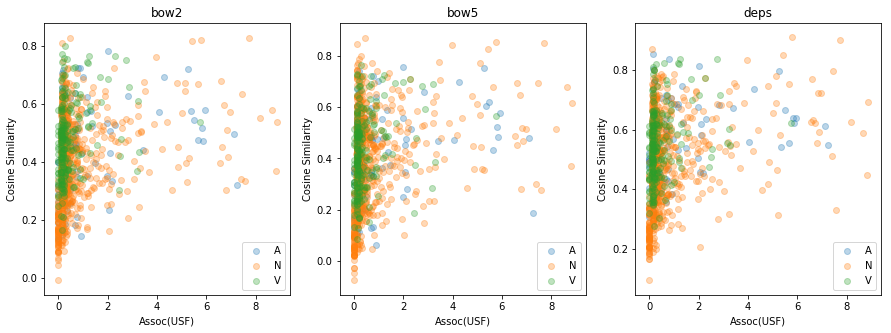

In [8]:
figure = plt.figure()
figure.set_size_inches(15, 5)

for i, (data, name) in enumerate([(bow2, 'bow2'), (bow5, 'bow5'), (deps, 'deps')]):
    yplot, xplot = score_simlex_pos(simlex, "Assoc(USF)", data)
    
    colours = ["blue", "green", "red"]
    plt.subplot(1, 3, i+1)
    for j, pos in enumerate(xplot.keys()):
        plt.scatter(xplot[pos], yplot[pos], alpha=0.3, label=pos)
    plt.legend()
    plt.xlabel("Assoc(USF)")
    plt.ylabel("Cosine Similarity")
    plt.title(name)
plt.show()

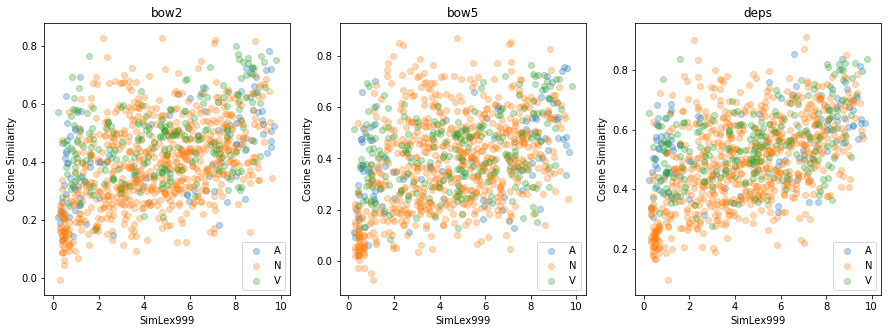

In [9]:
figure = plt.figure()
figure.set_size_inches(15, 5)
for i, (data, name) in enumerate([(bow2, 'bow2'), (bow5, 'bow5'), (deps, 'deps')]):
    yplot, xplot = score_simlex_pos(simlex, "SimLex999", data)
    
    colours = ["blue", "green", "red"]
    plt.subplot(1, 3, i+1)
    for j, pos in enumerate(xplot.keys()):
        plt.scatter(xplot[pos], yplot[pos], alpha=0.3, label=pos)
    plt.legend()
    plt.xlabel("SimLex999")
    plt.ylabel("Cosine Similarity")
    plt.title(name)
plt.show()

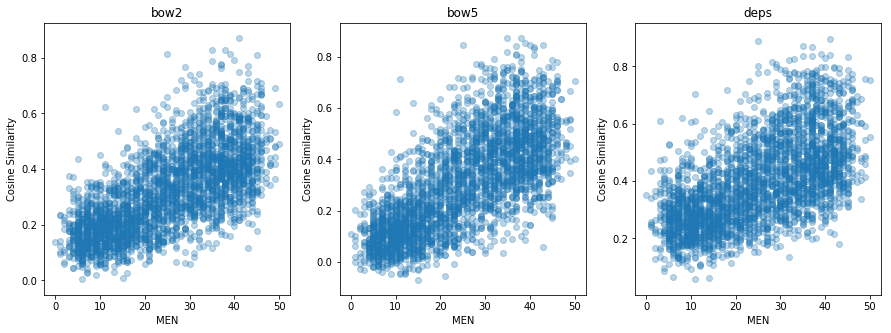

In [10]:
figure = plt.figure()
figure.set_size_inches(15, 5)
for i, (data, name) in enumerate([(bow2, 'bow2'), (bow5, 'bow5'), (deps, 'deps')]):
    yplot, xplot = score_men(men, data)
    plt.subplot(1, 3, i+1)
    plt.scatter(xplot, yplot, alpha=0.3)
    plt.xlabel("MEN")
    plt.ylabel("Cosine Similarity")
    plt.title(name)
plt.show()

### 3. Pearson's $\rho$ and Spearman's $\rho$

In [11]:
results = []
for i, (data, name) in enumerate([(bow2, 'bow2'), (bow5, 'bow5'), (deps, 'deps')]):
    embed_results = []
    gold = []
    embed_results, gold = score_men(men, data)
    spearman = spearmanr(embed_results, gold)
    pearson = pearsonr(embed_results, gold)
    results.append((name, "MEN", spearman[0], spearman[1], pearson[0], pearson[1]))

    embed_results, gold = score_simlex(simlex, "SimLex999", data)
    spearman = spearmanr(embed_results, gold)
    pearson = pearsonr(embed_results, gold)
    results.append((name, "SimLex", spearman[0], spearman[1], pearson[0], pearson[1]))

In [12]:
headers = ['Embeddings', 'Gold standard', 'Spearman\'s r',
           'Spearman p-value', 'Pearson\'s r', 'Pearson p-value' ]
print(tabulate(results, headers=headers, tablefmt="fancy_grid"))

╒══════════════╤═════════════════╤════════════════╤════════════════════╤═══════════════╤═══════════════════╕
│ Embeddings   │ Gold standard   │   Spearman's r │   Spearman p-value │   Pearson's r │   Pearson p-value │
╞══════════════╪═════════════════╪════════════════╪════════════════════╪═══════════════╪═══════════════════╡
│ bow2         │ MEN             │       0.699905 │       0            │      0.677698 │      0            │
├──────────────┼─────────────────┼────────────────┼────────────────────┼───────────────┼───────────────────┤
│ bow2         │ SimLex          │       0.414146 │       1.22681e-42  │      0.428459 │      7.993e-46    │
├──────────────┼─────────────────┼────────────────┼────────────────────┼───────────────┼───────────────────┤
│ bow5         │ MEN             │       0.723169 │       0            │      0.708236 │      0            │
├──────────────┼─────────────────┼────────────────┼────────────────────┼───────────────┼───────────────────┤
│ bow5         │ Si

### 4. Analogy Task

In [82]:
analogies = defaultdict(list)
with open(analogy_filename, 'r') as f:
    for line in f:
        if line[0] == ":":
            topic = line.split()[-1]
        else:
            analogies[topic].append(tuple(line.split()))

In [88]:
def analogy_task(analogies, embeddings):
    """Calculate the accuracy and MRR for embeddings on an analogy task.
    
    Args:
        analogies: dictionary with topics as keys and a list of word tuples as values
        embeddings: dictionary of word embeddings, words as keys and vectors as values
    Returns:
        float: accuracy
        float: MRR
    """
    for topic in analogies:
        correct = 0
        for (a, a_star, b, b_star) in tqdm(analogies[topic]):
            b_star_embed = embeddings[b] + (embeddings[a_star] - embeddings[a])
            b_star_approx = get_closest_word_to_vec(b_star_embed, embeddings)
            if b_star_approx == b_star:
                correct += 1
        print("Topic {}, accuracy {}.".format(topic, correct / len(analogies[topic])))

analogy_task(analogies, bow2)


  0%|                                          | 1/992 [00:01<30:49,  1.87s/it]


KeyboardInterrupt: 

In [89]:
import gensim
gensim.KeyedVectors(bow2)

ImportError: No module named 'gensim'

### 5. Clustering

100%|██████████████████████████████████████████████| 1999/1999 [00:00<?, ?it/s]


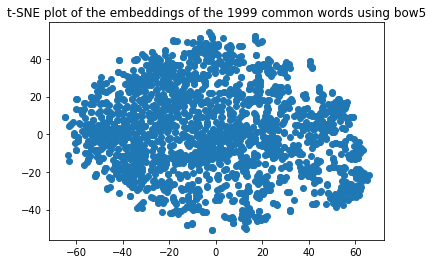

In [24]:
data = []
common_words = []
with open(common_words_filename, 'r') as f:
    for line in f:
        # 'fig.' is a word, changing it to 'fig' here.
        if line[-2] == '.':
            line = line[:-2]
        common_words.append(line.split()[0])
for key in tqdm(common_words):
    data.append(bow5[key])
embedding = TSNE()
result = embedding.fit_transform(data)
plt.scatter(result[:, 0], result[:, 1])
plt.title('t-SNE plot of the embeddings of the 1999 common words using bow5')
plt.show()

100%|██████████████████████████████████████████| 38/38 [01:16<00:00,  2.01s/it]


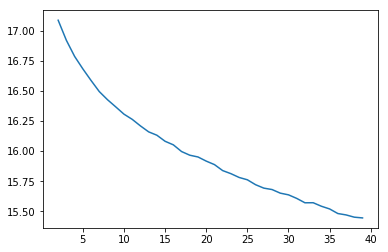

In [31]:
data = np.array(data)
whitened_data = whiten(data)
x = []
y = []
for k in tqdm(range(2,40)):
    centroids, error = kmeans(whitened_data, k)
    x.append(k)
    y.append(error)
plt.plot(x, y)
plt.show()

100%|██████████████████████████████████████████| 38/38 [01:11<00:00,  1.89s/it]


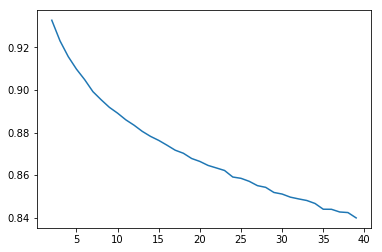

In [32]:
data = np.array(data)
whitened_data = whiten(data)
x = []
y = []
for k in tqdm(range(2,40)):
    centroids, error = kmeans(data, k)
    x.append(k)
    y.append(error)
plt.plot(x, y)
plt.show()